<a href="https://colab.research.google.com/github/Azimoj/Home-Credit-Default-Risk/blob/main/Model_Optimization_Bayesian_bal%26imbal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import gc
import time
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.model_selection import KFold, StratifiedKFold

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/p7/data/Df_train.csv')

In [ ]:
X = data.drop(['TARGET'],axis=1)
y= data['TARGET']

**Spliting**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X ,y,test_size = 0.2,random_state=0)
print('The shape of X_train is', X_train.shape)
print('The shape of X_test is', X_test.shape)
print('The shape of y_train is', y_train.shape)
print('The shape of y_test is', y_test.shape)

The shape of X_train is (246005, 896)
The shape of X_test is (61502, 896)
The shape of y_train is (246005,)
The shape of y_test is (61502,)


In [ ]:
del X,y

In [ ]:
X_train.drop(['SK_ID_CURR'],axis=1, inplace= True)
X_test.drop(['SK_ID_CURR'],axis=1, inplace= True)

### **Bayesian Optimization**

Bayesian optimization uses probability to find the minimum of a function. The final aim is to find the input value to a function which can gives us the lowest possible output value.It usually performs better than random,grid and manual search providing better performance in the testing phase and reduced optimization time. In Hyperopt, Bayesian Optimization can be implemented giving 3 three main parameters to the function fmin.

* Objective Function = defines the loss function to minimize.
* Domain Space = defines the range of input values to test (in Bayesian Optimization this space creates a probability distribution for each of the used Hyperparameters).
* Optimization Algorithm = defines the search algorithm to use to select the best input values to use in each new iteration.

https://github.com/krishnaik06/All-Hyperparamter-Optimization/blob/master/Hyper%20Parameter%20Optimization.ipynb

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from time import time

In [ ]:
! pip install bayesian_optimization

In [ ]:
from bayes_opt import BayesianOptimization

In [ ]:
# Définition de l'objective fonction
def lgbm_eval_1(num_leaves, max_depth, min_split_gain,
                min_child_weight, min_child_samples, subsample,
                learning_rate, colsample_bytree, reg_alpha, reg_lambda):
    '''
    Objective function for Bayesian Optimization of LightGBM's
    Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.

    Inputs: Hyperparamters to be tuned.
        boost, num_leaves, max_depth, min_split_gain, min_child_weight,
        min_child_samples, subsample, colsample_bytree, reg_alpha,
        reg_lambda

    Returns:
        CV ROC-AUC Score
    '''

    params = {
        'objective' : 'binary',
        'boosting_type' : 'goss',
#       'learning_rate' : 0.005,
        'n_estimators' : 10000,
        'n_jobs' : -1,
#       'class_weight' : 'balanced', # Balanced   
        'learning_rate' : learning_rate,     
        'num_leaves' : int(round(num_leaves)),
        'max_depth' : int(round(max_depth)),
        'min_split_gain' : min_split_gain,
        'min_child_weight' : min_child_weight,
        'min_child_samples' : int(round(min_child_samples)),
        'subsample': subsample,
        
        'colsample_bytree' : colsample_bytree,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'verbosity' : -1,
        'seed' : 0
    }
    
    stratified_cv = StratifiedKFold(n_splits=3, shuffle=True,
                                    random_state= 0)
    
    cv_preds = np.zeros(X_train.shape[0])
    for train_indices, cv_indices in stratified_cv.split(X_train,
                                                         y_train):

        x_tr = X_train.iloc[train_indices]
        y_tr = y_train.iloc[train_indices]
        x_cv = X_train.iloc[cv_indices]
        y_cv = y_train.iloc[cv_indices]

        lgbm_clf = LGBMClassifier(**params)
        lgbm_clf.fit(x_tr, y_tr, eval_set= [(x_cv, y_cv)],
                     eval_metric='auc', verbose=False,
                     early_stopping_rounds=200)

        cv_preds[cv_indices] = \
            lgbm_clf.predict_proba(x_cv,
                                   num_iteration=lgbm_clf.best_iteration_)[:,1]

    return roc_auc_score(y_train, cv_preds)

In [ ]:
lgbm_bayesian_opt_1 = \
    BayesianOptimization(lgbm_eval_1,
                         {'learning_rate' : (0.1, 0.5),
                          'num_leaves' : (25, 50),
                          'max_depth' : (8, 15),
                          'min_split_gain' : (0, 0.3),
                          'min_child_weight' : (5, 80),
                          'min_child_samples' : (5, 80),
                          'subsample' : (0.1, 1),
                          
                          'colsample_bytree' : (0.5, 1),
                          'reg_alpha' : (0.001, 0.3),
                          'reg_lambda' : (0.001, 0.3)})

bayesian_opt_1 = lgbm_bayesian_opt_1.maximize(n_iter=20, init_points=4)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7393   |  0.6783   |  0.4539   |  13.45    |  29.2     |  25.08    |  0.1471   |  36.53    |  0.2793   |  0.2804   |  0.6673   |
|  2        |  0.741    |  0.5838   |  0.3933   |  8.804    |  7.838    |  15.62    |  0.05095  |  42.27    |  0.2565   |  0.2713   |  0.9755   |
|  3        |  0.7445   |  0.6805   |  0.3403   |  9.718    |  13.06    |  22.41    |  0.2543   |  36.24    |  0.25     |  0.03173  |  0.8118   |
|  4        |  0.749    |  0.6329   |  0.2069   |  13.52    |  28.41    |  29.38    |  0.1234   |  49.14    |  0.1591   |  0.09715  |  0.9454   |
|  5        |  0.7492   |  0.6266   |  0.2642   |  10.3     |  54.13    |  38.53    |  0.1992   |  34.21    |  0.234    |  0

In [ ]:
#extracting the best parameters
target_values = []
for result in lgbm_bayesian_opt_1.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']

print('Best Hyperparamètres :\n')
print(best_params)

Best Hyperparamètres :

{'colsample_bytree': 0.7801084228402584, 'learning_rate': 0.10964168722958863, 'max_depth': 9.94505527159758, 'min_child_samples': 53.840653843571374, 'min_child_weight': 42.336365267396054, 'min_split_gain': 0.1548537971601916, 'num_leaves': 34.74967175140272, 'reg_alpha': 0.28757426331478686, 'reg_lambda': 0.029407724861703975, 'subsample': 0.18958664338512515}


**Sans le paramètre class_weight='balanced'**

In [ ]:
param_lgbm_bayesian_opt_1 = {'objective' : 'binary',
                             'boosting_type' : 'goss',
                             'n_jobs' : -1,
                             'colsample_bytree': 0.78, 
                             'learning_rate': 0.1, 
                             'max_depth': 10, 
                             'min_child_samples': 54, 
                             'min_child_weight': 42, 
                             'min_split_gain': 0.015, 
                             'num_leaves': 35, 
                             'reg_alpha': 0.28, 
                             'reg_lambda': 0.03, 
                             'subsample': 0.2,
                             'seed' : 0}

In [ ]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_bayesian_opt_1 = LGBMClassifier(**param_lgbm_bayesian_opt_1,
                                     #class_weight='balanced',
                                     force_col_wise=True)

In [ ]:
lgbm_bayesian_opt_1.fit(X_train, y_train)

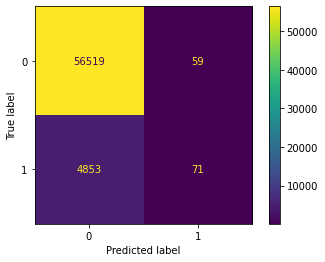

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(lgbm_bayesian_opt_1, X_test, y_test)  

In [ ]:
from sklearn import model_selection 
from sklearn.model_selection import KFold
# Create the kfold object
k_fold = KFold(n_splits = 5, shuffle = True, random_state = 0)

In [ ]:
test_predictions = lgbm_bayesian_opt_1.predict_proba(X_test, num_iteration = 10)[:, 1] / k_fold.n_splits

In [ ]:
AUROC_LGBM=roc_auc_score(y_test, test_predictions)
AUROC_LGBM

0.745876516733877

In [ ]:
y_predX= lgbm_bayesian_opt_1.predict(X_test)

In [ ]:
from sklearn.metrics import precision_score,recall_score,accuracy_score
precision_LGBM = accuracy_score(y_test, y_predX)
precision_LGBM

0.9199863419075802

In [ ]:
rappel_LGBM = recall_score(y_test, y_predX)
rappel_LGBM

0.015028432168968318

,thr,tpr,fpr
0,1.695000,0.000000,0.000000
1,0.695000,0.000203,0.000000
2,0.666234,0.000406,0.000000
3,0.661589,0.000406,0.000018
4,0.652332,0.000812,0.000018
...,...,...,...
8225,0.007681,0.999594,0.994980
8226,0.007679,0.999797,0.994980
8227,0.007376,0.999797,0.996023
8228,0.007374,1.000000,0.996023


AUC : 0.7660180223507749


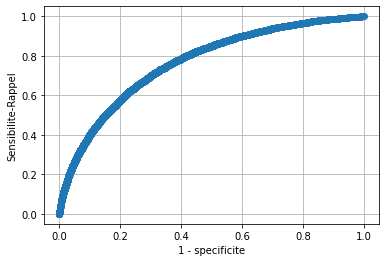

In [ ]:
from sklearn.metrics import roc_auc_score
import sklearn.metrics as me
[fpr, tpr, thr]  = me.roc_curve(y_test, lgbm_bayesian_opt_1.predict_proba(X_test)[:, 1])
#1-fpr correspond a la antispecifite pour la vrais specifite 1-valeur
#tpr le rappel , sensibilité
#thr le seuil 

df_roc = pd.DataFrame({'thr': thr, 'tpr': tpr, 'fpr': fpr})
plt.plot(fpr, tpr, marker='o')
plt.xlabel('1 - specificite')
plt.ylabel('Sensibilite-Rappel')
plt.grid()
display(df_roc)
#ceci est notre AUROC qui permet de comparer 
#AUROC_LGBM =roc_auc_score(y_test, clf_LGBM.predict_proba(X_test)[:, 1])

print('AUC : {}'.format(roc_auc_score(y_test, lgbm_bayesian_opt_1.predict_proba(X_test)[:, 1])))

In [ ]:
# indice du premier seuil pour lequel
#Taux de faux négatifs + taux de vrais positifs (sensibilité=rappel)=1
#on pose taux de faux negatifs =0.05 (5%)
# la sensibilité est supérieure à 0.95
idx = np.min(np.where(tpr > 0.95)) 

print("Sensitivity : {:.2f}".format(tpr[idx]))
print("Specificity : {:.2f}".format(1-fpr[idx]))
print("Threshold : {:.2f}".format(thr[idx]))

Sensitivity : 0.95
Specificity : 0.26
Threshold : 0.03


In [ ]:
# Métriques
from sklearn.metrics import roc_auc_score, average_precision_score, \
    fbeta_score, make_scorer

In [ ]:
f1_score_Lgbm = fbeta_score(y_test, y_predX, beta=1)
f01_score_Lgbm = fbeta_score(y_test, y_predX, beta=0.1)
f001_score_Lgbm = fbeta_score(y_test, y_predX, beta=0.01)

In [ ]:
print('f1 score:',f1_score_Lgbm)
print('f01 score:',f01_score_Lgbm)
print('f001 score:',f001_score_Lgbm)

f1 score: 0.029197080291970802
f01 score: 0.3847817133443163
f001 score: 0.50866849402443


In [ ]:
resultat1 =pd.DataFrame({ 'Model': ['LightGBM_OPT_imbalanced'], 'f1': [f1_score_Lgbm*100], 'f01': [f01_score_Lgbm*100], 'f001': [f001_score_Lgbm*100],
                      'AUROC':[AUROC_LGBM*100],'Precision':[precision_LGBM*100],'Recall':[rappel_LGBM*100]})

In [ ]:
resultat1

,Model,f1,f01,f001,AUROC,Precision,Recall
0,LightGBM_OPT_imbalanced,2.919708,38.478171,50.866849,74.587652,91.998634,1.502843


In [ ]:
resultat1.to_csv('/content/drive/MyDrive/p7/data/LightGBM_OPT_imbalanced.csv', index=False)

**Avec le paramètre class_weight='balanced'**

In [ ]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_bayesian_opt_1_bal = LGBMClassifier(**param_lgbm_bayesian_opt_1,
                                         class_weight='balanced',
                                         force_col_wise=True)

In [ ]:
lgbm_bayesian_opt_1_bal.fit(X_train, y_train)

LGBMClassifier(boosting_type='goss', class_weight='balanced',
               colsample_bytree=0.78, force_col_wise=True, max_depth=10,
               min_child_samples=54, min_child_weight=42, min_split_gain=0.015,
               num_leaves=35, objective='binary', reg_alpha=0.28,
               reg_lambda=0.03, seed=0, subsample=0.2)

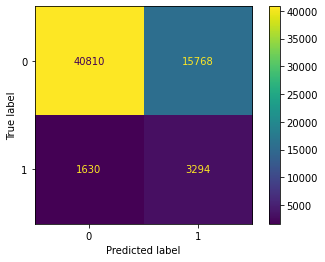

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(lgbm_bayesian_opt_1_bal, X_test, y_test) 

In [ ]:
from sklearn import model_selection 
from sklearn.model_selection import KFold
# Create the kfold object
k_fold = KFold(n_splits = 5, shuffle = True, random_state = 0)

In [ ]:
test_predictions = lgbm_bayesian_opt_1_bal.predict_proba(X_test, num_iteration = 10)[:, 1] / k_fold.n_splits

In [ ]:
AUROC_LGBM=roc_auc_score(y_test, test_predictions)
AUROC_LGBM

0.7453494932870399

In [ ]:
y_predX= lgbm_bayesian_opt_1_bal.predict(X_test)
y_predX

array([0, 0, 0, ..., 0, 1, 1])

In [ ]:
from sklearn.metrics import precision_score,recall_score,accuracy_score
precision_LGBM = accuracy_score(y_test, y_predX)
precision_LGBM

0.7171148905726643

In [ ]:
rappel_LGBM = recall_score(y_test, y_predX)
rappel_LGBM

0.670186839967506

,thr,tpr,fpr
0,1.946519,0.000000,0.000000
1,0.946519,0.000203,0.000000
2,0.945726,0.000203,0.000018
3,0.940690,0.000406,0.000018
4,0.934029,0.000406,0.000088
...,...,...,...
8214,0.054536,0.999594,0.997137
8215,0.054497,0.999797,0.997137
8216,0.047497,0.999797,0.998674
8217,0.047485,1.000000,0.998674


AUC : 0.7660729991842639


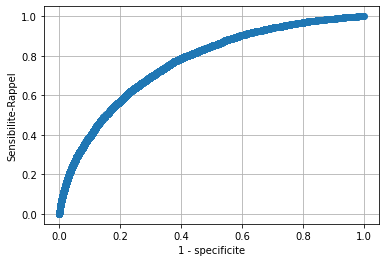

In [ ]:
from sklearn.metrics import roc_auc_score
import sklearn.metrics as me
[fpr, tpr, thr]  = me.roc_curve(y_test, lgbm_bayesian_opt_1_bal.predict_proba(X_test)[:, 1])
#1-fpr correspond a la antispecifite pour la vrais specifite 1-valeur
#tpr le rappel , sensibilité
#thr le seuil 

df_roc = pd.DataFrame({'thr': thr, 'tpr': tpr, 'fpr': fpr})
plt.plot(fpr, tpr, marker='o')
plt.xlabel('1 - specificite')
plt.ylabel('Sensibilite-Rappel')
plt.grid()
display(df_roc)
#ceci est notre AUROC qui permet de comparer 
#AUROC_LGBM =roc_auc_score(y_test, clf_LGBM.predict_proba(X_test)[:, 1])

print('AUC : {}'.format(roc_auc_score(y_test, lgbm_bayesian_opt_1_bal.predict_proba(X_test)[:, 1])))

In [ ]:
# indice du premier seuil pour lequel
#Taux de faux négatifs + taux de vrais positifs (sensibilité=rappel)=1
#on pose taux de faux negatifs =0.05 (5%)
# la sensibilité est supérieure à 0.95
idx = np.min(np.where(tpr > 0.95)) 

print("Sensitivity : {:.2f}".format(tpr[idx]))
print("Specificity : {:.2f}".format(1-fpr[idx]))
print("Threshold : {:.2f}".format(thr[idx]))

Sensitivity : 0.95
Specificity : 0.27
Threshold : 0.23


In [ ]:
# Métriques
from sklearn.metrics import roc_auc_score, average_precision_score, \
    fbeta_score, make_scorer

In [ ]:
f1_score_Lgbm = fbeta_score(y_test, y_predX, beta=1)
f5_score_Lgbm = fbeta_score(y_test, y_predX, beta=5)
f10_score_Lgbm = fbeta_score(y_test, y_predX, beta=10)

In [ ]:
print('f1 score:',f1_score_Lgbm)
print('f5 score:',f5_score_Lgbm)
print('f10 score:',f10_score_Lgbm)

f1 score: 0.27432561619352425
f5 score: 0.6032270538193835
f10 score: 0.651568318883361


In [ ]:
#https://www.youtube.com/watch?v=CV9FTCvQ32Q&t=637s
out = lgbm_bayesian_opt_1_bal.predict_proba(X_test)

LGBM prediction for sample 49 = [0.5842435 0.4157565]
Actual outcome =  0


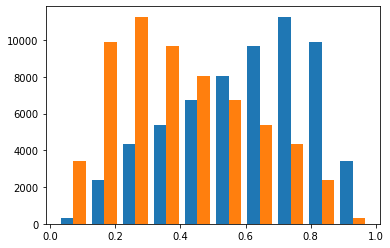

In [ ]:
plt.hist(out)
num= 49
print('LGBM prediction for sample', num, '=', out[num])
print('Actual outcome = ', y_train.iloc[num])

In [ ]:
resultat11=pd.DataFrame({ 'Model': ['LightGBM_OPT_balanced'], 'f1': [f1_score_Lgbm*100], 'f5': [f5_score_Lgbm*100], 'f10': [f10_score_Lgbm*100],
                      'AUROC':[AUROC_LGBM*100],'Precision':[precision_LGBM*100],'Recall':[rappel_LGBM*100]})

In [ ]:
resultat11

,Model,f1,f5,f10,AUROC,Precision,Recall
0,LightGBM_OPT_balanced,27.432562,60.322705,65.156832,74.655855,71.612305,67.018684


In [ ]:
resultat11.to_csv('/content/drive/MyDrive/p7/data/LightGBM_OPT_imbalanced.csv', index=False)

In [ ]:
ret= resultat1.append(resultat11)
ret

,Model,f1,f01,f001,AUROC,Precision,Recall,f5,f10
0,LightGBM_OPT_imbalanced,2.919708,38.478171,50.866849,74.587652,91.998634,1.502843,NaN,NaN
0,LightGBM_OPT_balanced,27.432562,NaN,NaN,74.655855,71.612305,67.018684,60.322705,65.156832


In [ ]:
res =pd.read_csv('/content/drive/MyDrive/p7/data/result_LightGBM.csv')
res

,Model,f1,f5,f10,AUROC,Precision,Recall
0,LightGBM_without_imputation & 0F,27.709772,59.982368,64.641107,74.412625,72.249683,66.429732
1,LightGBM_without_impute_with_F0,27.489575,60.283069,65.087906,74.412625,71.727749,66.937449
2,LightGBM_with_imputation & 0F,27.387926,60.245351,65.076582,74.150787,71.583038,66.937449
3,LightGBM_with_impute_without_0F,27.421572,60.181883,64.986246,74.150787,71.674092,66.835906


In [ ]:
X_train.to_csv('/content/drive/MyDrive/p7/data/X_train_fin.csv', index=False)
y_train.to_csv('/content/drive/MyDrive/p7/data/y_train_fin.csv', index=False)

In [ ]:
X_train.shape

(246005, 896)

In [ ]:
X_test.to_csv('/content/drive/MyDrive/p7/data/X_test_fin.csv', index=False)
y_test.to_csv('/content/drive/MyDrive/p7/data/y_test_fin.csv', index=False)

In [ ]:
pd.DataFrame(test_predictions).to_csv("/content/drive/MyDrive/p7/data/test_predictions.csv")

In [ ]:
import pickle
pickle.dump(lgbm_bayesian_opt_1_bal, open('drive/MyDrive/p7/best_model.sav', 'wb'))

In [ ]:
pickle.dump(X_train, open('drive/MyDrive/p7/X_train_fin.sav', 'wb'))
pickle.dump(y_train, open('drive/MyDrive/p7/y_train_fin.sav', 'wb'))
pickle.dump(X_test, open('drive/MyDrive/p7/X_test_fin.sav', 'wb'))
pickle.dump(y_test, open('drive/MyDrive/p7/y_test_fin.sav', 'wb'))


### **Feature importances**

In [ ]:
import pickle
lgbm_bayesian_opt_1_bal= pickle.load( open('drive/MyDrive/p7/pickle/best_model.pickle', 'rb'))

In [ ]:
feature_importances= lgbm_bayesian_opt_1_bal.feature_importances_
feature_importances = pd.DataFrame({'feature': list(X_train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

In [ ]:
pickle.dump(feature_importances, open('drive/MyDrive/p7/pickle/feature_importances.pickle', 'wb'))

In [ ]:
! pip install shap

In [ ]:
# Interprétation
import shap
shap.initjs()

**Global interpretability**

Summary plot

In [ ]:
# TreeExplainer - This explainer is used for models that are based on a tree-like decision tree, random forest, gradient boosting.
explainer = shap.TreeExplainer(lgbm_bayesian_opt_1_bal)
shap_values = explainer.shap_values(X_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


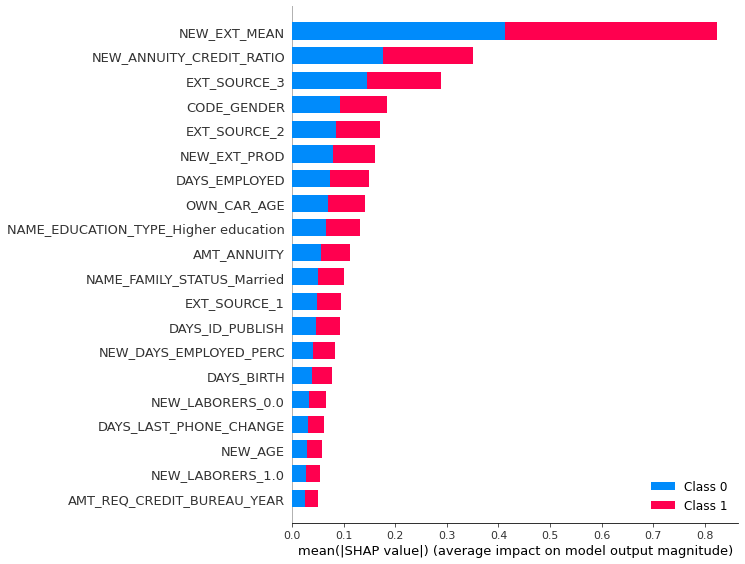

In [ ]:
# Summary plot
shap.summary_plot(shap_values, X_test)

* NEW_EXT_MEAN : EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'.mean
* NEW_ANNUITY_CREDIT_RATIO : AMT_ANNUITY / AMT_CREDIT
* EXT_SOURCE_3 : Normalized score from external data source.
* CODE_GENDER : 0_Male, 1_Female
* NEW_LABORERS_0.0 : Jobs with low risk of default

* NEW_AGE: DAYS_BIRTH / -365
* NEW_DAYS_EMPLOYED_PERC: DAYS_EMPLOYED / DAYS_BIRTH

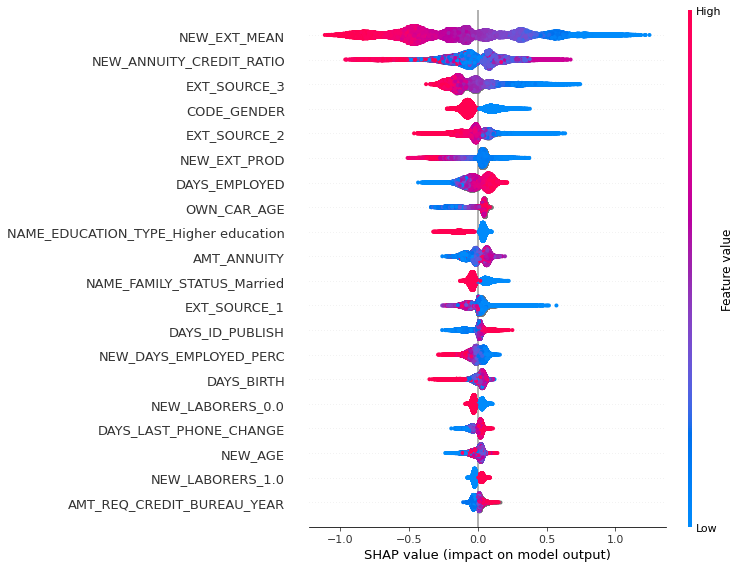

In [ ]:
shap.summary_plot(shap_values[1], X_test, show=False)
#https://www.youtube.com/watch?v=ZkIxZ5xlMuI

In [ ]:
explainer = shap.Explainer(lgbm_bayesian_opt_1_bal, X_test)
shap_values = explainer(X_train, check_additivity=False)

100%|===================| 245891/246005 [23:32<00:00]       

In [ ]:
shap.plots.bar(shap_values, max_display=40)